### MA3402 Estadística
## Tarea 3, Entrega 3: More Regresiones Lineales y PCA

**Profesor:** Joaquín Fontbona T.

**Auxiliares:** Javier Maass, Francisco Muñoz y Diego Olguín.

# Objetivo

El objetivo de esta tarea es el de introducir el concepto de estandarización, ajustar modelos utilizando Ridge y LASSO, utilizar LASSO para seleccionar variables y observar el efecto del Análisis de Componentes Principales (PCA) sobre un conjunto de datos.

# El Conjunto de Datos de Breast Cancer

El conjunto de datos de Breast Cancer (Cáncer de Mama) es un conjunto de datos ampliamente utilizado en el campo de la ciencia de datos y el aprendizaje automático. Este conjunto está destinado a la clasificación binaria, y se utiliza comúnmente para construir modelos que distingan entre tumores benignos y malignos. La información recopilada para cada caso se basa en diversas características derivadas de imágenes digitalizadas de masas mamarias.

En esta tarea trabajaremos con este conjunto de datos, aunque, en vez de realizar una clasificación, realizaremos una regresión lineal. Se puede "convertir" un problema de regresión a uno de clasificación (en este contexto en particular) de la siguiente forma:
$$
\hat y^{\mathrm{pred}}_i = \begin{cases}
0 & \text{si } \bar y_i < 0.5\\
1 & \text{si } \bar y_i \geq 0.5
\end{cases}
$$
donde $\bar y_i$ es la predicción de la regresión lineal.

## Importación de librerías y funciones útiles

Importaremos algunas librerías útiles que utilizaremos en el notebook. En las siguientes celdas encontrará el código necesario para instalar las librerías que utilizaremos.

In [ ]:
UPDATE = False  # Dejar como True si se desea actualizar a la última versión de sklearn

# PARA INSTALAR Y ACTUALIZAR SKLEARN
try:
    # Verificar que sklearn está instalado
    import sklearn
    print("Sklearn installed")
except:
    print("Installing sklearn...")
    !pip install --upgrade pip
    !python -m pip install scikit-learn
    print("\nHay que reiniciar el notebook!!!!")
finally:
    if UPDATE:
        !pip install --upgrade pip
        !python -m pip install --upgrade scikit-learn
        print("\nHay que reiniciar el notebook!!!!")
    import sklearn
    print(f"Sklearn version: {sklearn.__version__}")

# PARA INSTALAR Y ACTUALIZAR PANDAS >=V.1.3
try:
    # Verificar que pandas está instalado
    import pandas
    print("Pandas installed")

    # Verificar que la versión sea menor a 1.2
    from packaging import version
    print(f"Version of pandas: {pandas.__version__}")
    assert version.parse(pandas.__version__) >= version.parse("1.3")
except:
    print("Installing pandas...")
    !pip install --upgrade pip
    !python -m pip install --upgrade pandas

    import pandas
    print(f"pandas version: {pandas.__version__}")

    print("\nHay que reiniciar el notebook!!!!")

# PARA INSTALAR STATSMODELS
try:
    import statsmodels
    print("statsmodels installed")
except:
    print("installing statsmodels...")
    !pip install --upgrade pip
    !python -m pip install statsmodels
    print("\nHay que reiniciar el notebook!!!!")

Sklearn installed
Sklearn version: 1.1.2
Pandas installed
Version of pandas: 2.1.3
statsmodels installed


In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split

# Semilla para hacer resultados replicables
np.random.seed(seed=42)

# Para tener gráficos bonitos
sns.set_theme(
    context="notebook", 
    style="darkgrid", 
)

In [ ]:
# Para filtrar warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Obtenemos los datos, especificando la variable dependiente $y$ y las variables independientes $X$. 

Separamos los datos entre los de entrenamiento y los de testeo en proporción 2/3 y 1/3 respectivamente.

In [ ]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.rename(columns={col: col.replace(" ", "_") for col in df.columns}, inplace=True)

TARGET_NAME = "diagnosis"
INDEP_VARS = list(df.columns)
DEP_VARS = [TARGET_NAME]
df[TARGET_NAME] = data.target

df_train, df_test = train_test_split(
    df, test_size=0.33, random_state=42
)

df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Se puede obtener la documentación del conjunto de datos y de las variables a través del campo `DESCR`.

In [ ]:
# Descomentar para revisar la documentación
# print(data.DESCR)

Realizamos un gráfico de la matriz de correlaciones a través de la función `corr_matrix`. Recuerde que la correlación entre dos variables queda definida por el [coeficiente de correlación de Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
$$
\rho_{X, Y} = \frac{\mathrm{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$
En la entrada de Wikipedia se explican más detalles de este coeficiente. Pero a grandes rasgos, si tiene un coeficiente cercano a 1, significa que se encuentran correlacionadas (si una variable sube, usuamente la otra también) y si tiene un coeficiente cercano a -1, están anticorrelacionadas (si una variable sube, usualmente la otra baja).

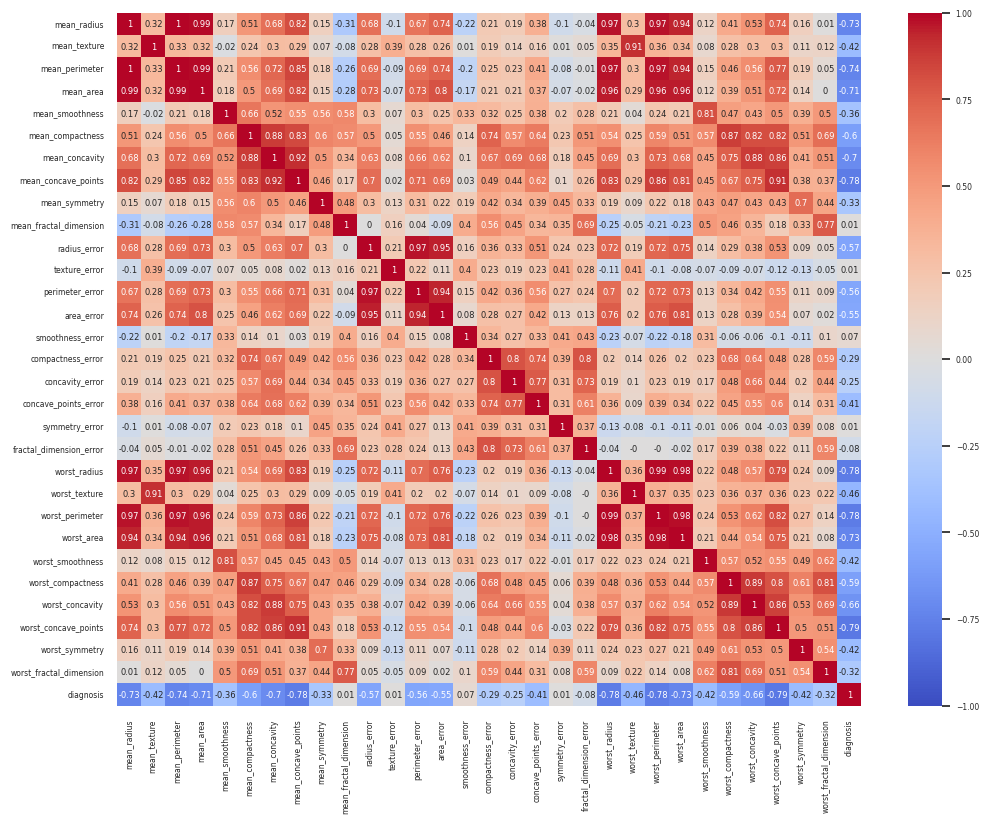

In [ ]:
def corr_matrix(correlation_matrix, context="notebook", figsize=(12, 9), font_scale=0.5, cmap="coolwarm"):
    with sns.plotting_context(context, font_scale=font_scale):
        plt.figure(figsize=figsize)
        sns.heatmap(
            data=correlation_matrix, 
            annot=True, 
            cmap=cmap,
            vmin=-1, vmax=1,
        )

df_corr_matrix = df.corr().round(2)
corr_matrix(df_corr_matrix)

# Transformaciones

La **estandarización** es un proceso utilizado en estadística y aprendizaje automático para transformar las variables de un conjunto de datos, de manera que tengan una media de cero y una desviación estándar de uno. Este proceso, también conocido como normalización, es comúnmente aplicado a las variables independientes en un modelo estadístico, como la regresión lineal, y es esencial en algoritmos que utilizan medidas de distancia, como el k-means clustering.

Dado un conjunto de datos $X = (x_{ij})_{ij} \in \mathbb{R}^{N\times p}$, con $N$ datos y $p$ características, esta transformación conciste en aplicar la siguiente fórmula:
$$
\tilde x_{ij} = \frac{x_{ij} - u_j}{s_j}
$$
donde $u_j = \frac{1}{N}\sum_{i=1}^{n} x_{ij}$ y $s_j = \sqrt{\frac{1}{N-1}\sum_{i=1}^{n}(x_{ij} - u_j)^2}$.

Al estandarizar las variables, se logran varias ventajas:

1. **Comparación Justa**: Las variables están en la misma escala, lo que facilita la comparación de sus efectos relativos en un modelo.

2. **Interpretación Mejorada**: Los coeficientes en modelos lineales se vuelven más interpretables, ya que representan el cambio en la variable objetivo por unidad de cambio en la variable estandarizada.

3. **Convergencia Rápida**: Algoritmos de optimización, como el descenso de gradiente, pueden converger más rápidamente cuando las variables están en la misma escala.

Y muy en particular, esta técnica tiene una mejora en el modelo lineal: como todas las variables (tanto las dependientes como independientes) tienen media cero, se puede asumir que el intercepto (el coeficiente $\beta_0$) es idénticamente nulo.

Cabe destacar que, una vez que se realiza esta transformación con datos $X$, una vez que lleguen nuevos datos, hay que transformarlos utilizando los mismos valores $u_j$ y $s_j$ del conjunto de datos original. Además, que cuando se realice una predicción, hay que realizar una transformación inversa sobre la variable predicha.

La siguiente celda implementa una estandarización sobre el conjunto de datos. Esto se implementa a través de la transformación [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) tanto para las variables independientes $X$ como a la variable independiente. Le sugerimos revisar la documentación del `StandardScaler` igualmente, para que tenga en cuenta qué cosas se pueden hacer con este transformador.

In [ ]:
def as_df(array, df, columns=None):
    """Retorna un DataFrame manteniendo los índices de `df` y los nombres de `columns`"""
    columns = columns or df.columns
    assert array.shape[0] == len(df), "La primera componente debe ser igual al largo de `df`"
    assert array.shape[1] == len(columns), "La segunda componente debe ser igual al largo de `columns`"
    return pd.DataFrame(array, index=df.index, columns=columns)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Crear scalers
X_scaler = StandardScaler().fit(df_train[INDEP_VARS])
y_scaler = StandardScaler().fit(df_train[DEP_VARS])

# Transformar 
X_train, y_train = X_scaler.transform(df_train[INDEP_VARS]), y_scaler.transform(df_train[DEP_VARS])
X_test, y_test = X_scaler.transform(df_test[INDEP_VARS]), y_scaler.transform(df_test[DEP_VARS])
X, y = X_scaler.transform(df[INDEP_VARS]), y_scaler.transform(df[DEP_VARS])

# Transformarlos a DataFrame
X_train, y_train = as_df(X_train, df_train, INDEP_VARS), as_df(y_train, df_train, DEP_VARS)
X_test, y_test = as_df(X_test, df_test, INDEP_VARS), as_df(y_test, df_test, DEP_VARS)
X, y = as_df(X, df, INDEP_VARS), as_df(y, df, DEP_VARS)

X_train.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
172,0.355820,-1.726647,0.413031,0.206435,2.150290,1.003954,1.447046,1.593877,0.595127,1.105740,...,0.511028,-1.409852,0.521794,0.373935,0.921112,0.722973,1.571401,1.056523,0.518443,0.989255
407,-0.373267,0.508813,-0.394700,-0.404509,-1.487959,-0.396650,-0.351529,-0.789623,-0.829284,-0.209972,...,-0.392232,0.241384,-0.473485,-0.414070,-1.632042,-0.371199,-0.432654,-0.896674,-0.632367,-0.114696
56,1.403358,-0.151449,1.347999,1.346734,0.671504,0.446346,0.548645,1.076488,0.414308,-0.420762,...,2.023321,0.428535,1.866926,2.175532,1.323014,0.675140,0.591964,1.463535,1.025874,-0.033698
497,-0.479417,-0.448568,-0.483319,-0.499007,-0.489778,-0.529469,-0.670468,-0.658181,-1.028554,-0.303656,...,-0.462189,-0.200822,-0.437993,-0.480572,-0.180875,0.007476,-0.337271,-0.136763,0.232321,-0.392242
301,-0.482211,0.159817,-0.484132,-0.523181,-0.835553,-0.043498,-0.262323,-0.467040,-0.087557,-0.023982,...,-0.585641,-0.411160,-0.577874,-0.577302,-1.157539,-0.223715,-0.399521,-0.584631,-0.320953,-0.333900


# Regularizaciones

Recordemos que en el modelo de regresión lineal, para $X = (x_{ij}) \in \mathbb{R}^{N\times p}$ y $y \in \mathbb{R}^{N}$, el problema que se intenta minimizar es el de los mínimos cuadrados:
$$
\begin{aligned}
    \min_{\beta} \sum_{i=1}^{N} (y_i - \beta^\top \cdot x_i)^2
\end{aligned}
$$
donde $\beta = (\beta_1,\ldots,\beta_p)^\top$ y $\beta^\top \cdot x_i = \sum_{j=1}^{p} \beta_j x_{ij}$ (si consideramos el intercepto, podemos extender $x_i$ para que la primera coordenada sea 1 y entonces $\beta^\top \cdot x_i = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}$). 

Sin embargo, cuando nos enfrentamos a conjuntos de datos con multicolinealidad o un gran número de variables independientes en comparación con las observaciones, la regresión lineal clásica podría sufrir de un sobreajuste.

En este contexto, surgieron técnicas de regularización cono LASSO (Least Absolute Shrinkage and Selection Operator) y Ridge para mejorar la estabilidad y la generalidad del modelo.

## Ridge Regression

Ridge introduce una penalización en la función de pérdida mediante la adición de la suma de los cuadrados de los coeficientes. Este modelo se puede plantear de la siguiente manera:

$$
\begin{aligned}
    \min_{\beta} \frac{1}{N}\sum_{i=1}^{N} (y_i - \beta^\top \cdot x_i)^2 + \alpha \| \beta \|^2_2 = \frac{1}{N}\sum_{i=1}^{N} (y_i - \beta^\top \cdot x_i)^2 + \alpha \sum_{j=1}^{p} \beta_j^2
\end{aligned}
$$
Esta penalización controla la magnitud de los coeficientes, evitando que tomen valores extremadamente grandes. Ajustando un parámetro de regularización $\alpha$, Ridge es eficaz para abordar la multicolinealidad, distribuyendo de manera uniforme la influencia entre las variables independientes.

## LASSO

En contraste, LASSO utiliza la suma de los valores absolutos de los coeficientes en su término de penalización.

$$
\begin{aligned}
    \min_{\beta} \frac{1}{2N}\sum_{i=1}^{N} (y_i - \beta^\top \cdot x_i)^2 + \alpha \| \beta \|_1 = \frac{1}{2N}\sum_{i=1}^{N} (y_i - \beta^\top \cdot x_i)^2 + \alpha \sum_{j=1}^{p} |\beta_j|
\end{aligned}
$$

Esta característica única conduce a la posibilidad de que algunos coeficientes se vuelvan exactamente cero, actuando como un método automático de selección de características. LASSO es valioso cuando se busca simplificar el modelo al eliminar algunas variables predictoras, proporcionando una perspectiva de selección de características junto con la regularización.

**Cree y ajuste los modelos [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) y [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) utilizando `X_train`, `y_train` y $\alpha=0.1$.**

*Tenga en consideración que **NO** hay que ajustar el intercepto, pues los datos están estandarizados.*

In [ ]:
import sklearn.linear_model as lm

ols = ...
ridge = ...
lasso = ...

## Métricas

**Registre en una tabla el [error cuadrático medio](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) y el [score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) (el coeficiente $R^2$) de los distintos modelos, utilizando tanto los datos de entrenamiento como los de testeo. Utilice la función `metrics_table` para calcular las métricas pedidas.**

*La función `metrics_table` destaca los mejores valores en negrita y con fondo azul, mientras que destaca en rojo los peores valores.*

Ejemplo de la tabla:

| Modelo | MSE en train | MSE en test | $R^2$ en train | $R^2$ en test |
| ---    | ---          | ---         | ---            | ---           |
| OLS    | **0.1234**   | 0.8526      | 0.2547         | **0.9877**    |
| Ridge  | 0.5678       | **0.1235**  | **0.9541**     | 0.1235        |
| LASSO  | 0.9876       | 0.4567      | 0.3578         | 0.2354        |

In [ ]:
modelos = {
    "OLS": ols,
    "Ridge": ridge,
    "LASSO": lasso,
}

def metrics_table(
    models, 
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
):
    from sklearn.metrics import mean_squared_error as mse
    from itertools import product

    table = pd.DataFrame({
        "modelo": models.keys(),
        "MSE en train": [pd.NA for _ in models],
        "MSE en test": [pd.NA for _ in models],
        "R^2 en train": [pd.NA for _ in models],
        "R^2 en test": [pd.NA for _ in models],
    }).set_index("modelo")

    datasets = [
        ("train", X_train, y_train),
        ("test", X_test, y_test),
    ]

    for (name, X_, y_), (model_name, model) in product(datasets, models.items()):
        y_pred = model.predict(X_)
        if isinstance(model, (lm.Lasso, lm.LassoLarsIC)):
            y_pred = y_pred.reshape(-1, 1)
        table[f"MSE en {name}"][model_name] = mse(y_, y_pred)
        table[f"R^2 en {name}"][model_name] = model.score(X_, y_)

    table_style = table.style

    table_style.highlight_min(["MSE en train", "MSE en test"], props="background-color: lightblue; font-weight: bold")
    table_style.highlight_max(["R^2 en train", "R^2 en test"], props="background-color: lightblue; font-weight: bold")
    table_style.highlight_max(["MSE en train", "MSE en test"], color="lightpink")
    table_style.highlight_min(["R^2 en train", "R^2 en test"], color="lightpink")
    table_style.format(precision=4)

    return table_style

In [ ]:
# Celda para hacer la tabla

**¿Qué puede concluir a partir de la tabla? Comente acerca del MSE y $R^2$ en el conjunto de entrenamiento en el modelo de regresión lineal "clásico", en comparación con el conjunto de testeo.**
*<u>Respuesta</u>*: Soy una respuesta!

---
**¿La regularización mejoró el resultado de las predicciones? Comente para los caso en el conjunto de entrenamiento y de testeo.**
*<u>Respuesta</u>*: Soy una respuesta!

## Más Métricas: La Matriz de Confusión

La **matriz de confusión** es una herramienta comúnmente utilizada en el campo de la clasificación para evaluar el rendimiento de un modelo, comparando sus predicciones con las clases reales de un conjunto de datos. Esta matriz organiza la clasificación de las instancias en cuatro categorías distintas:

1. **Verdaderos Positivos (VP)**: Son los casos en los que el modelo predijo correctamente que una instancia pertenece a una clase específica.

2. **Falsos Positivos (FP)**: Representan las instancias en las que el modelo predijo incorrectamente que una instancia pertenece a una clase cuando en realidad no lo hace. También se conocen como errores de Tipo I.

3. **Verdaderos Negativos (VN)**: Son los casos en los que el modelo predijo correctamente que una instancia no pertenece a una clase específica.

4. **Falsos Negativos (FN)**: Corresponden a las instancias en las que el modelo predijo incorrectamente que una instancia no pertenece a una clase cuando en realidad sí lo hace. También se conocen como errores de Tipo II.

**Genere la matriz de confusión, utilizando la función `confusion_matrix`, para los tres modelos sobre el conjunto de testeo.**

*Tenga en cuenta que debe de volver a transformar la variable $y$. Esto se puede realizar utilizando el método [StandardScaler.inverse_transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.inverse_transform)*

In [ ]:
def confusion_matrix(y_true, y_pred, title=None, cmap="viridis"):
    from sklearn import metrics
    
    cm = metrics.confusion_matrix(y_true, y_pred)
    with sns.plotting_context():
        disp = metrics.ConfusionMatrixDisplay(cm)
        disp.plot(cmap=cmap)
        plt.title(title)
        plt.show()

In [ ]:
# Agregue en esta y en más celdas las matrices de confusión

**Complementando la respuesta anterior, ¿La regularización mejoró el resultado de las predicciones? Comente en términos de falsos positivos y falsos negativos**
*<u>Respuesta</u>*: Soy una respuesta!

## Selección de Variables

Antes de empezar con la parte más importante de esta sección, se le proporcionará el código de los algoritmos *Forward Selection* y *Backward Elimination* que implementan automáticamente la selección de variables. Estos algoritmos fueron implementadas (a mano) en la tarea anterior. Además, como estas funciones retornan las variables seleccionadas, actualizaremos la función que realiza la tabla de las métricas para que se le entregue directamente las variables.

In [ ]:
def forward_selection(df, verbose=False):
    formula = "diagnosis ~ 1"
    variables = set(df.columns[:-1])
    selected_variables = set()

    while True:
        if verbose: print("\n" + "=" * 20)

        # Guardar el antiguo modelo
        last_model = smf.ols(
            formula=formula,
            data=df,
        ).fit()

        # Seleccionar la mejor variable
        pvalues = dict()
        for var in variables:
            model_ = smf.ols(
                formula=formula + f" + {var}",
                data=df,
            ).fit()
            pvalues[var] = model_.pvalues[var]

        # Actualizar 
        best_var = min(pvalues, key=pvalues.get)
        variables -= {best_var}
        formula += " + " + best_var

        # Obtener el nuevo modelo
        curr_model = smf.ols(
            formula=formula,
            data=df,
        ).fit()
        
        if verbose:
            print(f"{best_var = }")
            print(f"{variables = }")
            print(f"{formula = }")

            print(f"{last_model.info_criteria('aic') = :.4f}")
            print(f"{curr_model.info_criteria('aic') = :.4f}")

        # Detenerse si el criterio de información sube
        if curr_model.info_criteria("aic") > last_model.info_criteria("aic"):
            break

        selected_variables |= {best_var}

    return list(selected_variables)


def backward_elimination(df, verbose=False):
    selected_variables = set(df.columns[:-1])

    while True:
        if verbose: print("\n" + "=" * 20)
        last_model = smf.ols(
            formula="diagnosis ~ " + " + ".join(selected_variables),
            data=df,
        ).fit()

        worst_var = last_model.pvalues.idxmax()

        variables = selected_variables.copy()
        variables -= {worst_var}

        curr_model = smf.ols(
            formula="diagnosis ~ " + " + ".join(variables),
            data=df,
        ).fit()
        
        if verbose:
            print(f"{worst_var = }")
            print(f"{variables = }")

            print(f"{last_model.info_criteria('aic') = :.4f}")
            print(f"{curr_model.info_criteria('aic') = :.4f}")

        # Detenerse si el criterio de información sube
        if curr_model.info_criteria("aic") > last_model.info_criteria("aic"):
            break

        selected_variables = variables

    return list(selected_variables)


forward_columns = forward_selection(df_train)
backward_columns = backward_elimination(df_train)

ols_forward = lm.LinearRegression(fit_intercept=False).fit(X_train[forward_columns], y_train)
ols_backward = lm.LinearRegression(fit_intercept=False).fit(X_train[backward_columns], y_train)

**Actualice la tabla anterior para incluir los nuevos modelos utilizando la selección de variables forward y backward. Genere además las matrices de confunsión asociadas a estos modelos. En la siguiente celda de código hay una actualización de la función para considerar los casos *forward* y *backward*. La tabla debería de verse así:**

| Modelo        | MSE en train | MSE en test | $R^2$ en train | $R^2$ en test |
| ---           | ---          | ---         | ---            | ---           |
| OLS           | **0.1234**   | 0.8526      | 0.2547         | **0.9877**    |
| Ridge         | 0.5678       | **0.1235**  | **0.9541**     | 0.1235        |
| LASSO         | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS forward   | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS backward  | 0.9876       | 0.4567      | 0.3578         | 0.2354        |

In [ ]:
def metrics_table(
    models, 
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    forward_columns=forward_columns,
    backward_columns=backward_columns,
):
    from sklearn.metrics import mean_squared_error as mse
    from itertools import product

    table = pd.DataFrame({
        "modelo": models.keys(),
        "MSE en train": [pd.NA for _ in models],
        "MSE en test": [pd.NA for _ in models],
        "R^2 en train": [pd.NA for _ in models],
        "R^2 en test": [pd.NA for _ in models],
    }).set_index("modelo")

    datasets = [
        ("train", X_train, y_train),
        ("test", X_test, y_test),
    ]

    for (name, X_, y_), (model_name, model) in product(datasets, models.items()):
        if "forward" in model_name:
            X_ = X_[forward_columns]
        if "backward" in model_name:
            X_ = X_[backward_columns]
        y_pred = model.predict(X_)
        if isinstance(model, (lm.Lasso, lm.LassoLarsIC)):
            y_pred = y_pred.reshape(-1, 1)
        table[f"MSE en {name}"][model_name] = mse(y_, y_pred)
        table[f"R^2 en {name}"][model_name] = model.score(X_, y_)

    table_style = table.style

    table_style.highlight_min(["MSE en train", "MSE en test"], props="background-color: lightblue; font-weight: bold")
    table_style.highlight_max(["R^2 en train", "R^2 en test"], props="background-color: lightblue; font-weight: bold")
    table_style.highlight_max(["MSE en train", "MSE en test"], color="lightpink")
    table_style.highlight_min(["R^2 en train", "R^2 en test"], color="lightpink")
    table_style.format(precision=4)

    return table_style

In [ ]:
# Agregue aquí y en más celdas la respuesta

**En comparación a las regularizaciones, ¿La selección de variables mejoró el resultado de las predicciones? Comente utilizando la tabla de métricas y la matriz de confusión.**
*<u>Respuesta</u>*: Soy una respuesta!

### Selección de Variables con LASSO

Una de las características más interesantes de utilizar la regularización LASSO, es que se puede utilizar para seleccionar las variables más relevantes. En efecto, a medida que el hiperparámetro $\alpha$ aumenta, los coeficientes $\beta_i$ de la regresión se ajustan a 0 uno después del otro.

Esta propiedad hace que el estimador LASSO sea una herramienta interesante para la selección de variables. Esto es porque, en comparación con los algoritmos *forward selection* y *backward elimination*, la selección de variables se realiza de manera automática. Esto se puede evidenciar al ejecutar la siguiente celda, que grafica la evolución de los coeficientes $(\beta_j)_{j=1}^p$ en función de $\alpha$.

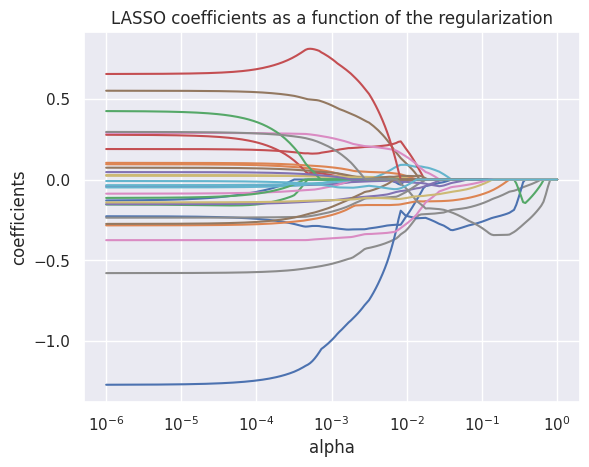

In [ ]:
n_alphas = 200
alphas = np.logspace(-6, 0, n_alphas)

coefs = []
for a in alphas:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        lasso_ = lm.Lasso(alpha=a, fit_intercept=False, max_iter=1000).fit(X_train, y_train)
        coefs.append(lasso_.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("LASSO coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

**Comente acerca del comportamiento de las curvas de los parámetros $\beta_i$. ¿Cómo se comportan con valores bajos de $\alpha$? ¿Y cuando $\alpha$ aumenta?**
*<u>Respuesta</u>*: Soy una respuesta!

Ahora bien, sabemos que permite eliminar una a una las variables que se encuentran correlacionadas, pero ¿cómo lo utilizamos para escoger un modelo?

Para esto podemos utilizar el criterio de información de Akaike (AIC), de la misma manera que en los algoritmos recién vistos. Con esto, simplemente basta escoger un $\alpha$ tal que minimice el criterio de información del modelo. Convenientemente, Sklearn ya implementa esta funcionalidad por defecto, a través del modelo [LassoLarsIC](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html#sklearn.linear_model.LassoLarsIC).

**Implemente este modelo para los criterios de información AIC y BIC**

In [ ]:
lasso_aic = ...
lasso_bic = ...

**Extienda la tabla anterior para incluir el error cuadrático medio y el score de los dos modelos anteriores, actualizando los valores destacados respectivamente. Genere además las matrices de confusión asociadas a los modelos. La tabla debería de tener la siguiente forma:**

| Modelo        | MSE en train | MSE en test | $R^2$ en train | $R^2$ en test |
| ---           | ---          | ---         | ---            | ---           |
| OLS           | **0.1234**   | 0.8526      | 0.2547         | **0.9877**    |
| Ridge         | 0.5678       | **0.1235**  | **0.9541**     | 0.1235        |
| LASSO         | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS forward   | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS backward  | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| LASSO AIC     | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| LASSO BIC     | 0.9876       | 0.4567      | 0.3578         | 0.2354        |

In [ ]:
# Soy una celda de código

**En comparación a los algoritmos de selección de variables *forward* y *backward*, ¿La forma de seleccionar variables utilizando LASSO mejoró el resultado de las predicciones? ¿A qué se puede deber este comportamiento? Comente utilizando la tabla de métricas y la matriz de confusión.**
*<u>Respuesta</u>*: Soy una respuesta!

# Análisis de Componentes Principal (PCA)


El Análisis de Componentes Principales (PCA) es una técnica de reducción de dimensionalidad que se utiliza para simplificar la complejidad en un conjuntos de datos de alta dimensionalidad, conservando al mismo tiempo la variabilidad presente en los datos. La idea principal detrás del PCA es transformar el conjunto de datos original en un nuevo sistema de coordenadas, donde las nuevas dimensiones, llamadas componentes principales, capturan la mayor parte de la variabilidad de los datos. 

Recordemos que realizar un PCA corresponde a buscar una matriz de componentes principales $V \in \mathbb R^{p\times p}$,los valores singulares $d_1 \geq d_2 \geq \ldots \geq d_r$ de la matriz $D = \mathrm{diag}(d_1, \ldots, d_r, 0, \ldots, 0) \in \mathbb R^{N \times p}$ y la matriz $UD = (X - \bar X)V$ con $U \in \mathbb R^{N \times N}$, donde las matrices $U$, $D$ y $V$ vienen dadas por la descomposición en valores singulares (SVD):
$$
X = U D V
$$

De las grandes razones por la que se ocupa PCA se encuentran:
* **Reducción de dimensionalidad**: Permite representar los datos en un espacio de menor dimensión, lo que facilita la visualización y reduce la complejidad computacional.

* **Conservación de la información importante**: A pesar de reducir la dimensionalidad, PCA busca retener la mayor cantidad posible de la variabilidad original en los datos.

* **Eliminación de la multicolinealidad**: Las nuevas dimensiones son ortogonales entre sí, lo que ayuda a eliminar la multicolinealidad en los datos originales.

## Proyección en el Plano 2D

Una aplicación interesante del PCA es que, cuando se proyecta en los primeros 2 ejes principales, se puede observar una representación 2-dimensional de los datos. Por ejemplo, en la siguiente celda se observa una proyección de los datos que hemos considerado.

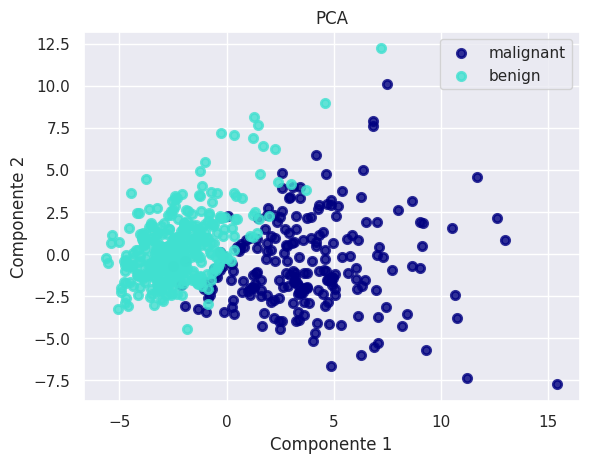

In [ ]:
from sklearn.decomposition import PCA

y = data.target
target_names = data.target_names

pca = PCA(n_components=2).fit(X)
X_r = pca.transform(X)

plt.figure()
colors = ["navy", "turquoise"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

plt.show()

**¿Qué se puede observar en el gráfico? ¿Por qué sucede esto?**
*<u>Respuesta</u>*: Soy una respuesta!

## La Fracción de la Varianza Explicada

Se puede demostrar que la fracción de varianza explicada se calcula por medio de:
$$
\begin{aligned}
\frac{\sum_{i=1}^q d_i^2}{\sum_{i=1}^r d_i^2}
\end{aligned}
$$
donde $q \leq r$ el número de componentes escogidas en el PCA y $r$ el rango de la matriz de los datos, $X\in\mathbb R^{N\times p}$. Esta cantidad nos dice la varianza que explican las primeras $q$ componentes del PCA. Uno desea que este ratio sea lo más cercano a 1 para que la proyección de $X$ sobre un subespacio de dimensión $q$ (generada por la matriz $V_q \in \mathbb R^{p \times q}$, las primeras $q$ columnas de $V$) refleje la mayor variabilidad original de los datos, manteniendo una baja dimensionalidad.

Esta cantidad puede ser revisada directamente en Sklearn a través de la propiedad `explained_variance_ratio_`. Sin embargo, hay que utilizar la suma acumulada, para ver como al añadir la siguiente componente, se explica mayor varianza.

In [ ]:
pca = PCA().fit(X_train)
max_comps = 5

for i, evr in enumerate(pca.explained_variance_ratio_.cumsum()[:max_comps]):
    print(f"{i+1}: {evr*100:.4f}%")

1: 43.2034%
2: 63.0569%
3: 72.8651%
4: 79.3654%
5: 84.5164%


Una ventaja de utilizar Sklearn es que uno puede escoger el nivel de varianza deseada, y escoge las primeras componentes que hagan eso posible. Esto se puede observar en la siguiente celda:

In [ ]:
pca_90 = PCA(n_components=0.90).fit(X_train)
print(f"{pca_90.n_components_ = }")
pca_95 = PCA(n_components=0.95).fit(X_train)
print(f"{pca_95.n_components_ = }")
pca_99 = PCA(n_components=0.99).fit(X_train)
print(f"{pca_99.n_components_ = }")

pca_90.n_components_ = 7
pca_95.n_components_ = 10
pca_99.n_components_ = 17


## Análisis de Factores

Otra aplicación que se puede hacer utilizando PCA es que la matriz $V_q$ nos proporciona los vectores singulares. Se pueden estudiar estos vectores (digamos, el vector $i$) para saber cuál es la ponderación que le está dando PCA a las compontes originales para explicar la componente $i$ de la proyección. 

Una visualización de los ejes principales se puede ver con el siguiente código.

<AxesSubplot: >

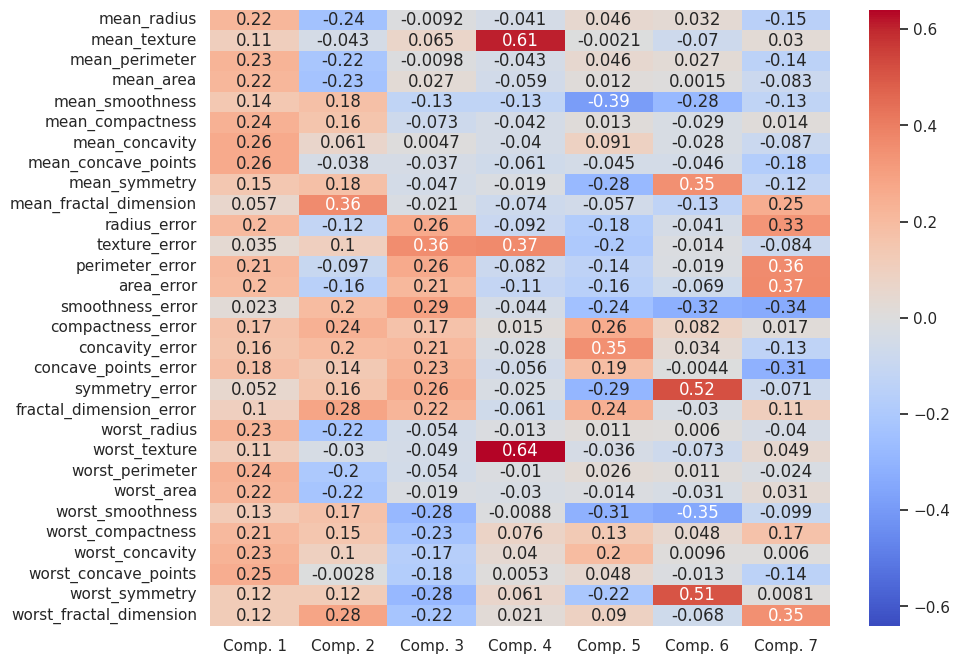

In [ ]:
# El modelo de PCA que se analizará
pca_ = pca_90

# Número de componentes a visualizar
n_comps = None  # Por defecto, utiliza los n componentes de pca_
n_comps = n_comps or pca_.n_components_

feature_names = pca_.feature_names_in_

# Creación de un DataFrame con las componentes
components = pca_.components_[:n_comps].T
df_components = pd.DataFrame(
    components,
    columns=[f"Comp. {i+1}" for i in range(n_comps)],
    index=feature_names,
)

# Se pueden eliminar algunas componentes para visualizar mejor el efecto de otras componentes
# del df_components["Comp. 4"]

vmax = df_components.abs().max().max()

plt.figure(figsize=(10, 8))
sns.heatmap(
    data=df_components, 
    annot=True, 
    cmap="coolwarm",
    vmin=-vmax, vmax=vmax,
)

**Observe como en cada componente hay coeficientes asociados a las columnas del dataset original que se "activan" más que otras. ¿Tienen alguna relación con las variables correlacionadas del dataset original? En la celda siguiente está el código para generar una matriz de correlaciones.**
*<u>Respuesta</u>*: Soy una respuesta!

---
**¿Puede interpretar a qué grupo está representando cada componente principal? Comente acerca de las componentes 4, 6 y 7. Como sugerencia, puede eliminar ciertas columnas del DataFrame para observar colores más nítidos.**
*<u>Respuesta</u>*: Soy una respuesta!

In [ ]:
# Matriz de correlaciones! descomente para visualizar.
# df_corr_matrix = df.corr().round(2)
# corr_matrix(df_corr_matrix)

## Utilizando PCA para hacer Regresiones

Hasta ahora sabemos que se puede utilizar PCA para realizar una reducción de dimensionalidad, manteniendo la variabilidad presente en los datos. Además, sabemos que estas componentes "intentan explicar con pocas dimensiones, algo que es de alta dimensión". Pero PCA tiene otra cosa muy interesante: las transformaciones que se realizan utilizando este método, no están correlacionadas entre sí. Esto se puede observar en la celda siguiente:

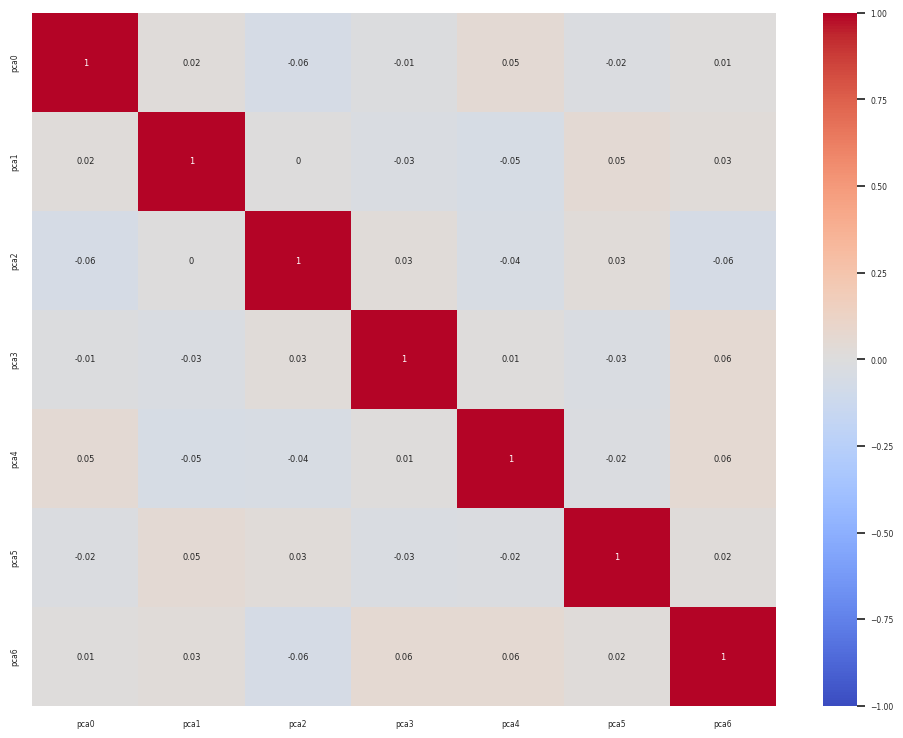

In [ ]:
X_ = pca_90.transform(X)

df_X_ = pd.DataFrame(X_, columns=pca_90.get_feature_names_out())

corr_matrix(df_X_.corr().round(2))

¿Para qué sirve esto? sirve para realizar una regresión lineal más fácilmente, pues uno de los supuestos que se realiza en una regresión lineal es que las variables no estén correlacionadas entre sí (qué es literalmente lo que ocurre al utilizar PCA). Por tanto, la estrategia que seguiremos será la siguiente:

1. Realizar PCA para bajar el número de dimensiones.
2. Realizar una regresión lineal sobre las variables transformadas utilizando PCA.
3. Realizar predicciones utilizando la regresión lineal.

Estos pasos se pueden implementar en la siguiente celda:

In [ ]:
ols_pca_90 = lm.LinearRegression(fit_intercept=False)
ols_pca_95 = lm.LinearRegression(fit_intercept=False)
ols_pca_99 = lm.LinearRegression(fit_intercept=False)

ols_pca_models = {
    "OLS PCA 90%": ols_pca_90,
    "OLS PCA 95%": ols_pca_95,
    "OLS PCA 99%": ols_pca_99,
}

for pca_, ols_ in zip([pca_90, pca_95, pca_99], ols_pca_models.values()):
    ols_.pca = pca_
    X_train_ = pca_.transform(X_train)
    ols_.fit(X_train_, y_train)

**Genere la tabla de métricas utilizando la función `metrics_table`, incuyendo los nuevos tres modelos creados, y genere la matriz de confusión de la regresión utilizando el PCA que explica el 99% de la variabilidad.**

La tabla debería de verse así:

| Modelo        | MSE en train | MSE en test | $R^2$ en train | $R^2$ en test |
| ---           | ---          | ---         | ---            | ---           |
| OLS           | **0.1234**   | 0.8526      | 0.2547         | **0.9877**    |
| Ridge         | 0.5678       | **0.1235**  | **0.9541**     | 0.1235        |
| LASSO         | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS forward   | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS backward  | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| LASSO AIC     | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| LASSO BIC     | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS PCA 90%   | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS PCA 95%   | 0.9876       | 0.4567      | 0.3578         | 0.2354        |
| OLS PCA 99%   | 0.9876       | 0.4567      | 0.3578         | 0.2354        |

En la siguiente celda se encuentra una actualización de la función `metrics_table`.

In [ ]:
def metrics_table(
    models, 
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    forward_columns=forward_columns,
    backward_columns=backward_columns,
):
    from sklearn.metrics import mean_squared_error as mse
    from itertools import product


    table = pd.DataFrame({
        "modelo": models.keys(),
        "MSE en train": [pd.NA for _ in models],
        "MSE en test": [pd.NA for _ in models],
        "R^2 en train": [pd.NA for _ in models],
        "R^2 en test": [pd.NA for _ in models],
    }).set_index("modelo")

    datasets = [
        ("train", X_train, y_train),
        ("test", X_test, y_test),
    ]

    for (name, X_, y_), (model_name, model) in product(datasets, models.items()):
        if "forward" in model_name:
            X_ = X_[forward_columns]
        if "backward" in model_name:
            X_ = X_[backward_columns]
        if "PCA" in model_name:
            X_ = model.pca.transform(X_)
        y_pred = model.predict(X_)
        if isinstance(model, (lm.Lasso, lm.LassoLarsIC)):
            y_pred = y_pred.reshape(-1, 1)
        table[f"MSE en {name}"][model_name] = mse(y_, y_pred)
        table[f"R^2 en {name}"][model_name] = model.score(X_, y_)

    table_style = table.style

    table_style.highlight_min(["MSE en train", "MSE en test"], props="background-color: lightblue; font-weight: bold")
    table_style.highlight_max(["R^2 en train", "R^2 en test"], props="background-color: lightblue; font-weight: bold")
    table_style.highlight_max(["MSE en train", "MSE en test"], color="lightpink")
    table_style.highlight_min(["R^2 en train", "R^2 en test"], color="lightpink")
    table_style.format(precision=4)

    return table_style

In [ ]:
# Soy una celda de código

**¿Cómo se comportan los modelos OLS utilizando PCA en comparación con el resto de modelos? ¿Resulta en una mejora?**
*<u>Respuesta</u>*: Soy una respuesta!

---
**De los modelos resumidos en la tabla de métricas (desde *OLS* hasta *OLS PCA 99%*), ¿Cuál de todos los modelos utilizaría para predecir un tumor, si este fuera un contexto real? Reflexione utilizando las matrices de confusión, y reflexionano en términos de los errores tipo I y II. Puede utilizar alguna métrica que se deriva de la matiz de confusión, vista en cátedra.**
*<u>Respuesta</u>*: Soy una respuesta!

# (OPCIONAL) La Regresión Logística

Como hemos comentado desde el inicio de esta tarea, estamos interpretando este problema de clasificación, como uno de regresión. Sin embargo, hay un mejor modelo para este contexto: La Regresión Logística. 

Utilizando los datos, puede utilizar la regresión logística, implementada en Sklearn, para resolver este problema. A partir del modelo, puede generar las métricas y matrices de confusión para observar como el desempeño mejora utilizando este modelo.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=05da59f1-7b9f-4970-8d32-7a5e3b8b8a3d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>